- **File Name**: treinamento_modelo.ipynb
- **Author**: Rafael Takeguma Goto
- **Version**: 1.0
- **Created at**: 2025/02/09
- **Updated at**: 2025/02/09

### Description: 
Notebook for the training and testing of a lithofacies Random Forest Classifier

In [1]:
import sys
import os
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import joblib

sys.path.append(os.path.abspath(os.path.join('..\..')))
from utils.data_plotting import *

### Reading the data set
The data set consists of a csv file, which is the result of the concatenation of the csv files generated from the fusion of the extraction of the dlis files with the agp files of each well, followed by the application of the following processes:
- constant filters
- null filters
- DCAL and DRHO filters
- reclassification of the metamorphic lithology

In [2]:
path_pocos_pre_transicao = '..\..\..\data\Dados-filtrados-concatenados\pocos_pre_transicao_v3.csv'

data_from_csv = pd.read_csv(path_pocos_pre_transicao)

data = pd.DataFrame(data_from_csv)

### Function to create, train and test the model
Creates function cria_modelo_extra_trees(dados, unidades), which takes as parameters the data of lithologies, profiles and "unidades" (if "unidades" is True) and returns the trained model.

In [3]:
my_y_train = 0
my_y_test = 0
def create_random_forest_model(data, units=bool):
    """
    Função que treina, testa e retorna o modelo.
    Divide os dados armazenados em dados em 2/3 para treinamento do modelo, 
    e 1/3 para teste do modelo.
    Utiliza os dados de treinamento armazenados em X_train e y_train 
    para treinar o modelo de classificação. 
    De forma semelhante, utiliza os dados de teste armazenados em X_test e y_test 
    para testar a acurácia do modelo.
    Por fim, retorna o modelo e a acurácia média e o desvio padrão da acurácia.
    

    Args:
        dados(DataFrame): DataFrame pandas que contém os dados das curvas, litologias e unidades
        unidades(bool): Verdadeiro ou Falso. Unidades serão variáveis preditivas ou não.

    Returns:
        modelo(sklearn.ensemble._forest.RandomForestClassifier): Modelo treinado
        y_pred(numpy.ndarray): Dados preditos para serem usados na matriz de confusão
        y_test(pandas.core.series.Series): Dados de teste para serem usados na matriz de confusão
        acuracia_media(float): Acurácia média do modelo
        desvio_padrao_acuracia(float): Desvio padrão da acurácia do modelo
    """
    # Define se as unidades geológicas serão incluídas ou não
    if units == False:
        # Define as variáveis preditivas que serão utilizadas (apenas propriedades de perfis, sem unidades geológicas) 
        variaveis_preditivas = ['GR', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE']
    else:
        # Define as variáveis preditivas que serão utilizadas (propriedades de perfis e unidades geológicas)
        variaveis_preditivas = ['GR', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE', 'Unidade_nivel_membro_BAN_BAN',
       'Unidade_nivel_membro_BAR_BAR', 'Unidade_nivel_membro_BAT_BAT',
       'Unidade_nivel_membro_COT_SAP', 'Unidade_nivel_membro_EMB_EMB',
       'Unidade_nivel_membro_MUR_CPS', 'Unidade_nivel_membro_MUR_IBU',
       'Unidade_nivel_membro_MUR_OIT', 'Unidade_nivel_membro_PDO_PDO',
       'Unidade_nivel_membro_RIA_ANG', 'Unidade_nivel_membro_RIA_MAR',
       'Unidade_nivel_membro_RIA_TQR', 'Unidade_nivel_membro_SER_SER']

    # Separa as variáveis preditivas e armazena em X
    X = data[variaveis_preditivas] 

    # Separa a variável alvo (litologia) e armazena em y
    y = data['Litologia']   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

    print(y_test)
    # Treina o modelo
    modelo = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)

    # Faz previsões com o modelo
    y_pred = modelo.predict(X_test)

    # Calcula a acuracia
    acuracia = accuracy_score(y_test, y_pred)
    print(f"Acurácia do modelo: {acuracia:2f}")

    """
    # Validação cruzada para calcular a acurácia média e o desvio padrão da acurácia
    scores = cross_val_score(modelo, X, y, cv=5)
    acuracia_media = np.mean(scores)
    desvio_padrao_acuracia = np.std(scores)
    print(f"Acurácia média: {acuracia_media:.2f}")
    print(f"Desvio padrão da acurácia: {desvio_padrao_acuracia:.2f}")
    """

    return modelo, X_train, X_test, y_train, y_test, y_pred

### Extra Trees Model Without Undersampling and With Units

In [4]:
model_01, X_train, X_test, y_train, y_test, y_pred = create_random_forest_model(data, units=True)

21652    CALCILUTITO
10178    CALCILUTITO
16397       FOLHELHO
26887       FOLHELHO
4981         ARENITO
            ...     
31967       FOLHELHO
29840        ARENITO
16921        ARENITO
14936       FOLHELHO
27826    CALCARENITO
Name: Litologia, Length: 12434, dtype: object
Acurácia do modelo: 0.853225


### Metrics Report

In [5]:
# Gerar relatório de métricas
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    ANIDRITA       0.91      0.90      0.91       413
     ARENITO       0.82      0.87      0.84      2788
 CALCARENITO       0.90      0.80      0.85       582
 CALCILUTITO       0.83      0.72      0.77      2185
CONGLOMERADO       0.92      0.86      0.89       317
    DOLOMITO       0.95      0.65      0.77       116
      FILITO       1.00      0.94      0.97        65
    FOLHELHO       0.85      0.89      0.87      5264
     GRANITO       1.00      0.99      1.00       156
     SILTITO       0.86      0.72      0.78       179
       XISTO       0.99      1.00      0.99       369

    accuracy                           0.85     12434
   macro avg       0.91      0.85      0.88     12434
weighted avg       0.85      0.85      0.85     12434



### Confusion Matrix

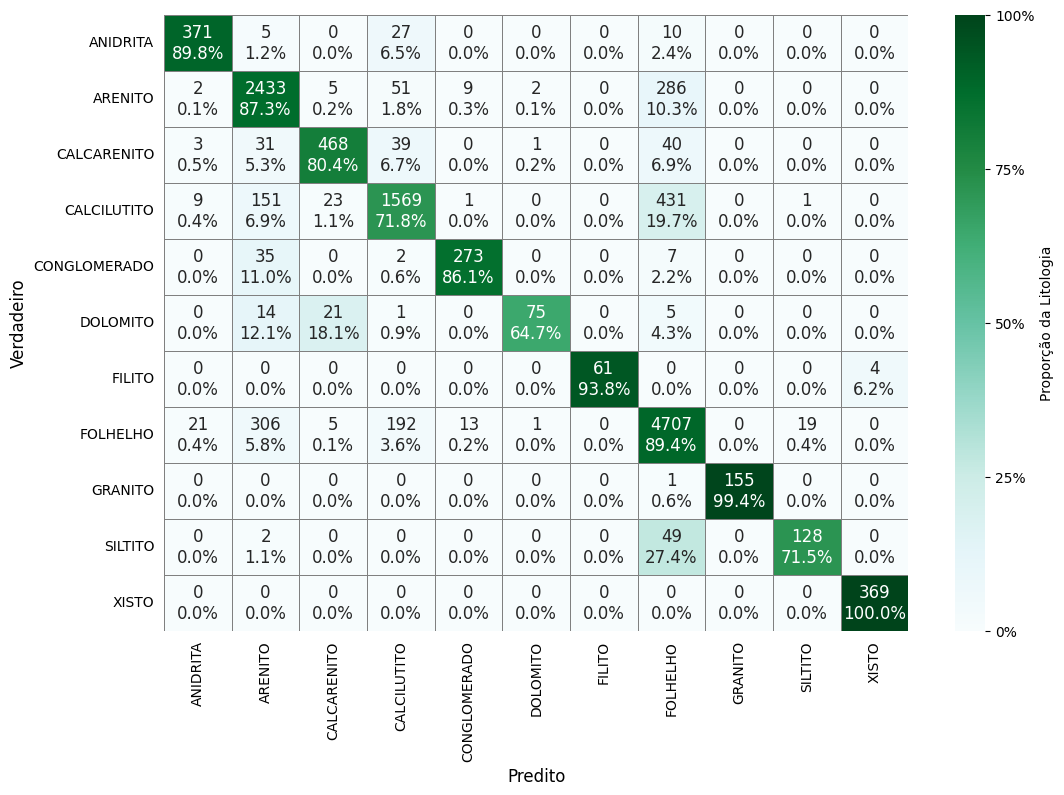

In [6]:
confusion_matrix_01 = confusion_matrix(y_test, y_pred)
cria_matriz_confusao(confusion_matrix_01, model_01)